In [131]:
suMin = float("inf")
suMax = -float("inf")
spMin = float("inf")
spMax = -float("inf")

In [132]:
def getData(uFd, pFd):
    global suMin
    global suMax
    global spMin
    global spMax
    print("working on file %s %s" % (uFd.name, pFd.name))
    x = []
    y = []
    while True:
        uL = uFd.readline()
        pL = pFd.readline()
        if not uL and pL: raise Exception("Different # lines")
        if uL and not pL: raise Exception("Different # lines")
        if not uL and not pL: break
            
        t1 = uL.split(",")[0]
        su = float(uL.split(",")[1])
        if su != float("inf") and su != -float("inf") and su < suMin: suMin = su
        if su != float("inf") and su != -float("inf") and su > suMax: suMax = su
            
        t2 = pL.split(",")[0]
        sp = float(pL.split(",")[1])
        if sp != float("inf") and sp != -float("inf") and sp < spMin: spMin = sp
        if sp != float("inf") and sp != -float("inf") and sp > spMax: spMax = su

            
        if t1 != t2: raise Exception("Inconsistent label, %s %s" % (pL, uL))
        
        x.append([su, sp]) #UA, PATH score
        if t1 == "m": y.append([1,0]) #one-hot
        elif t1 == "b": y.append([0,1]) #one-hot
        else: raise Exception("Invalid label, %s %s" % (pL, uL))

    return x, y

In [133]:
SEQ_LEN = 40
ua_data = '../hmm/UA_DATA/ua-5-fold/ua%d' % SEQ_LEN 
path_data = '../hmm/PATH_DATA/path-5-fold/path%d' % SEQ_LEN

folds = []
for f in range(1,6):
    
    uTrain = open("%s/ua.train%d.txt" % (ua_data, f), "r")
    pTrain = open("%s/path.train%d.txt" % (path_data, f), "r")
    uTest = open("%s/ua.test%d.txt" % (ua_data, f), "r")
    pTest = open("%s/path.test%d.txt" % (path_data, f), "r")
    
    xTrain, yTrain = getData(uTrain, pTrain)
    xTest, yTest = getData(uTest, pTest)
    folds.append([xTrain, yTrain, xTest, yTest])

    print("fold %d: " % f)
    print("train: ", len(xTrain), len(yTrain))
    print("test: ", len(xTest), len(yTest))

#replace INF
suMax += 1
suMin -= 1
spMax += 1
spMin -= 1
for xTrain, yTrain, xTest, yTest in folds:
    for i in range(len(xTrain)):
        if xTrain[i][0] == float("inf"): xTrain[i][0] = suMax
        if xTrain[i][0] == -float("inf"): xTrain[i][0] = suMin
        if xTrain[i][1] == float("inf"): xTrain[i][1] = spMax
        if xTrain[i][1] == -float("inf"): xTrain[i][1] = spMin 
    for i in range(len(xTest)):
        if xTest[i][0] == float("inf"): xTest[i][0] = suMax
        if xTest[i][0] == -float("inf"): xTest[i][0] = suMin
        if xTest[i][1] == float("inf"): xTest[i][1] = spMax
        if xTest[i][1] == -float("inf"): xTest[i][1] = spMin 

#normalized it to 0 to 1
for xTrain, yTrain, xTest, yTest in folds:
    for i in range(len(xTrain)):
        xTrain[i][0] = (xTrain[i][0] - suMin) / (suMax - suMin)
        xTrain[i][1] = (xTrain[i][1] - spMin) / (spMax - spMin)
    for i in range(len(xTest)):
        xTest[i][0] = (xTest[i][0] - suMin) / (suMax - suMin)
        xTest[i][1] = (xTest[i][1] - spMin) / (spMax - spMin)

print("done")

working on file ../hmm/UA_DATA/ua-5-fold/ua40/ua.train1.txt ../hmm/PATH_DATA/path-5-fold/path40/path.train1.txt
working on file ../hmm/UA_DATA/ua-5-fold/ua40/ua.test1.txt ../hmm/PATH_DATA/path-5-fold/path40/path.test1.txt
fold 1: 
train:  1673 1673
test:  399 399
working on file ../hmm/UA_DATA/ua-5-fold/ua40/ua.train2.txt ../hmm/PATH_DATA/path-5-fold/path40/path.train2.txt
working on file ../hmm/UA_DATA/ua-5-fold/ua40/ua.test2.txt ../hmm/PATH_DATA/path-5-fold/path40/path.test2.txt
fold 2: 
train:  1641 1641
test:  431 431
working on file ../hmm/UA_DATA/ua-5-fold/ua40/ua.train3.txt ../hmm/PATH_DATA/path-5-fold/path40/path.train3.txt
working on file ../hmm/UA_DATA/ua-5-fold/ua40/ua.test3.txt ../hmm/PATH_DATA/path-5-fold/path40/path.test3.txt
fold 3: 
train:  1660 1660
test:  412 412
working on file ../hmm/UA_DATA/ua-5-fold/ua40/ua.train4.txt ../hmm/PATH_DATA/path-5-fold/path40/path.train4.txt
working on file ../hmm/UA_DATA/ua-5-fold/ua40/ua.test4.txt ../hmm/PATH_DATA/path-5-fold/path40/p

fold 0 : cm = 
[[ 1.  0.]
 [ 1.  0.]]
fold 1 : cm = 
[[ 1.  0.]
 [ 1.  0.]]
fold 2 : cm = 
[[ 1.  0.]
 [ 1.  0.]]
fold 3 : cm = 
[[ 1.  0.]
 [ 1.  0.]]
fold 4 : cm = 
[[ 1.  0.]
 [ 1.  0.]]
fold 1 has accuracy: 0.864661654135
fold 2 has accuracy: 0.800464037123
fold 3 has accuracy: 0.837378640777
fold 4 has accuracy: 0.982905982906
fold 5 has accuracy: 0.720250521921
5 fold min 0.720250521921, max 0.982905982906, avg 0.841132167372


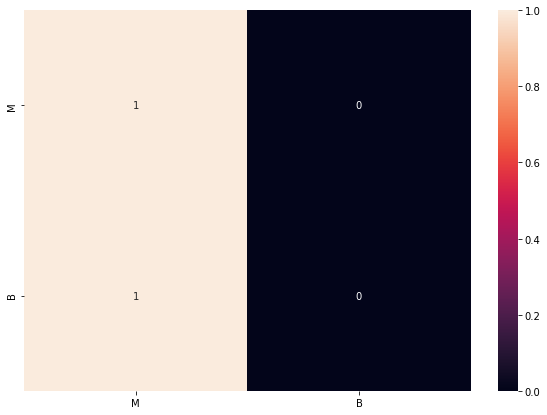

In [134]:
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def getCate(arr):
    print(arr.shape)
    l = []
    for i in range(arr.shape[0]):
        if np.argmax(arr[i]) == 0: l.append(-1)
        else: l.append(1)
    return l

def getModel():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

fold_acc = []
cms = []
for fold_num in range(5):
    xTrain, yTrain, xTest, yTest = folds[fold_num]
    numTests = len(yTest)

    xTrain = np.array(xTrain)
    xTest = np.array(xTest)

    #Neural Network
#     yTrain = np.array(yTrain)
#     yTest = np.array(yTest)
#     model = getModel()
#     model.fit(xTrain, yTrain, epochs=20, batch_size=32, validation_data=(xTest, yTest), verbose=0)
#     fold_acc.append(model.evaluate(xTest, yTest)[1])
#     cm = confusion_matrix(getCate(yTest), getCate(model.predict(xTest)))
#     cm = normalize(cm, axis=1, norm='l1')
#     cms.append(cm)
#     print("fold %d : cm = \n%s" % (fold_num, cm))
    
        
    #SVM
    yTrain = np.array([a.index(max(a)) for a in yTrain]) #convert back one-hot to label
    yTest = np.array([a.index(max(a)) for a in yTest])
    kernel =  'rbf' #‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
    clf = SVC(kernel=kernel)
    clf.fit(xTrain, yTrain)
    fold_acc.append(clf.score(xTest, yTest))
    if kernel == 'linear': print("fold %d : coef = %s" % (fold_num, clf.coef_))
    cm = confusion_matrix(yTest, clf.predict(xTest))
    cm = normalize(cm, axis=1, norm='l1')
    cms.append(cm)
    print("fold %d : cm = \n%s" % (fold_num, cm))

cm = cms[0]
for i in range(1,len(cms)): cm += cms[i]
cm = cm / len(cms)
df_cm = pd.DataFrame(cm, index = [i for i in "MB"], columns = [i for i in "MB"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
    
for fold_num in range(5):
    print("fold %s has accuracy: %s" % (fold_num+1, fold_acc[fold_num]))
print("5 fold min %s, max %s, avg %s" % (min(fold_acc), max(fold_acc), sum(fold_acc)/5,))